# Bitcoin transaction graph


In [616]:
import os

import json
from pprint import pprint

import requests
import requests_cache

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from hiveplot import HivePlot

from node2vec import node2vec as n2v


plt.style.use('ggplot')
%matplotlib inline

In [5]:
BASE_URL = "https://blockchain.info/"
TIMEOUT = 10

T_GENESIS =1231006505000
ms_per_day = 1000*60*60*24

# Set path of file for caching API calls
requests_cache.install_cache('../bci')

## Query by block height

In [496]:
query_blockchain = True
if query_blockchain:
    payload = None
    max_height = 50000
    block_list = []
    multi_trans_blocks = []
    for height in range(max_height):
        if height % 500 == 0:
            print("Reading block {0}".format(height))
        resource = 'block-height/{0}?format=json'.format(height)
        response_content = requests.get(BASE_URL + resource, payload, timeout=TIMEOUT).content
        json_response = json.loads(response_content)
        ##pprint(json_response)
        if json_response['blocks'][0]['n_tx'] > 1:
            #print("Multiple transactions at height {0}".format(height))
            multi_trans_blocks.append(json_response['blocks'])
        block_list.append(json_response['blocks'])
    block_list_flat = [item for sublist in block_list for item in sublist]
    
    # Write to file
    with open('../blockchain_list_flat.json', 'w') as outfile:
        json.dump(block_list_flat, outfile)
else: # Load from disk
    with open('../blockchain_list_flat.json') as infile:    
        block_list_flat = json.load(infile)

Reading block 0
Reading block 500
Reading block 1000
Reading block 1500
Reading block 2000
Reading block 2500
Reading block 3000
Reading block 3500
Reading block 4000
Reading block 4500
Reading block 5000
Reading block 5500
Reading block 6000
Reading block 6500
Reading block 7000
Reading block 7500
Reading block 8000
Reading block 8500
Reading block 9000
Reading block 9500
Reading block 10000
Reading block 10500
Reading block 11000
Reading block 11500
Reading block 12000
Reading block 12500
Reading block 13000
Reading block 13500
Reading block 14000
Reading block 14500
Reading block 15000
Reading block 15500
Reading block 16000
Reading block 16500
Reading block 17000
Reading block 17500
Reading block 18000
Reading block 18500
Reading block 19000
Reading block 19500
Reading block 20000
Reading block 20500
Reading block 21000
Reading block 21500
Reading block 22000
Reading block 22500
Reading block 23000
Reading block 23500
Reading block 24000
Reading block 24500
Reading block 25000
Read

## Parse the transactions in the blocks

In [497]:
tx_in_list = []
tx_out_list = []
tx_in_dfs = []
tx_out_dfs = []
#for block in [block_list_flat[multi] for multi in mts]:
for block in block_list_flat:
    height = block['height']
    
    for i_tx in range(block['n_tx']):
        tx_hash = block['tx'][i_tx]['hash']
        for in_dict in block['tx'][i_tx]['inputs']:

            if 'prev_out' in in_dict.keys():
                prev_out_dict = {}
                for key, val in in_dict['prev_out'].items():
                    prev_out_dict['prev_' + key] = val
                prev_out_dict = {**{'height': height, 'tx_hash': tx_hash}, **prev_out_dict}
                tx_in_list.append(prev_out_dict)
                    
            else:
                tx_in_dict = {**{'height': height, 'tx_hash': tx_hash}, **in_dict}
                tx_in_list.append(tx_in_dict)
                
            
        for out_dict in block['tx'][i_tx]['out']:
            tx_out_dicts = {**{'height': height, 'tx_hash': tx_hash}, **out_dict}
            tx_out_list.append(tx_out_dicts)
tx_in_df = pd.DataFrame(tx_in_list)
tx_out_df = pd.DataFrame(tx_out_list)

In [498]:
all_transactions = pd.merge(tx_out_df, tx_in_df, on = 'tx_hash', how = 'outer')
#                            left_on = ['addr', 'tx_index'], 
#                            right_on = ['prev_addr', 'prev_tx_index'])
transactions = all_transactions.loc[pd.notnull(all_transactions['prev_addr']), :]
mining_transactions = all_transactions.loc[pd.notnull(all_transactions['script_y']), :]
#print("Number of unique public keys: {0}".format(len(np.unique(transactions['prev_addr']))))
all_transactions.head(10)

,addr,addr_tag,addr_tag_link,height_x,n,script_x,spent,tx_hash,tx_index,type,...,prev_addr_tag_link,prev_n,prev_script,prev_spent,prev_tx_index,prev_type,prev_value,script_y,sequence,witness
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,Genesis of Bitcoin,https://en.bitcoin.it/wiki/Genesis_block,0,0,4104678afdb0fe5548271967f1a67130b7105cd6a828e0...,False,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,14849,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104455468652054696d65732030332f4a61...,4.294967e+09,
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,NaN,NaN,1,0,410496b538e853519c726a2c91e61ec11600ae1390813a...,False,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,14854,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104,4.294967e+09,
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,NaN,NaN,2,0,41047211a824f55b505228e4c3d5194c1fcfaa15a456ab...,False,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,14855,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010b,4.294967e+09,
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,NaN,NaN,3,0,410494b9d3e76c5b1629ecf97fff95d7a4bbdac87cc260...,False,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,14856,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010e,4.294967e+09,
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,NaN,NaN,4,0,4104184f32b212815c6e522e66686324030ff7e5bf08ef...,False,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,14857,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d011a,4.294967e+09,
5,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu,NaN,NaN,5,0,410456579536d150fbce94ee62b47db2ca43af0a730a04...,False,63522845d294ee9b0188ae5cac91bf389a0c3723f084ca...,14858,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0120,4.294967e+09,
6,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a,NaN,NaN,6,0,410408ce279174b34c077c7b2043e3f3d45a588b85ef4c...,False,20251a76e64e920e58291a30d4b212939aae976baca40e...,14859,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0123,4.294967e+09,
7,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM,NaN,NaN,7,0,4104a59e64c774923d003fae7491b2a7f75d6b7aa3f356...,False,8aa673bc752f2851fd645d6a0a92917e967083007d9c16...,14860,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012b,4.294967e+09,
8,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj,NaN,NaN,8,0,4104cc8d85f5e7933cb18f13b97d165e1189c1fb3e9c98...,False,a6f7f1c0dad0f2eb6b13c4f33de664b1b0e9f22efad599...,14861,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012c,4.294967e+09,
9,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S,NaN,NaN,9,0,410411db93e1dcdb8a016b49840f8c53bc1eb68a382e97...,True,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,14862,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0134,4.294967e+09,


In [500]:
# Keep only a few columns for graph analyses
cols = {('addr', 'addr_to'),
       ('prev_addr', 'addr_from'),
        ('height_y', 'height'),
       ('spent', 'spent_flag'),
       ('value', 'value')}

trans4graph = transactions[[c for c, _ in cols]].rename(columns = dict(cols))
#    .rename(dict(cols))
mining4graph = mining_transactions[[c for c, _ in cols]].rename(columns = dict(cols))

In [501]:
# Fill in "mining" as address from for mining transactions
mining4graph['addr_from'] = 'mining'
mining4graph.head()

,addr_to,spent_flag,addr_from,value,height
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,False,mining,5000000000,0
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,False,mining,5000000000,1
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,False,mining,5000000000,2
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,False,mining,5000000000,3
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,False,mining,5000000000,4


In [502]:
# Recombine
graph_df = pd.concat([trans4graph, mining4graph], axis=0).sort_values('height')
graph_df.head(13)

,addr_to,spent_flag,addr_from,value,height
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,False,mining,5000000000,0
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,False,mining,5000000000,1
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,False,mining,5000000000,2
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,False,mining,5000000000,3
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,False,mining,5000000000,4
5,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu,False,mining,5000000000,5
6,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a,False,mining,5000000000,6
7,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM,False,mining,5000000000,7
8,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj,False,mining,5000000000,8
9,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S,True,mining,5000000000,9


In [503]:
print(len(set(graph_df['addr_to'])))
graph_df['addr_to'].value_counts().head()

50420


12higDjoCCNXSA95xZMWUdPvXNmkAduhWv    1457
1Cp18yeabUg14CNp2HGwKisDoixiGgzmeT     814
199QiJj1miojVSAop7gpAamscHd77r12ET     443
19k8nToWwMGuF4HkNpzgoVAYk4viBnEs5D     383
1EXnCUbRoV7U6tzqXH9DFx5sZ1e8uFLCA2     382
Name: addr_to, dtype: int64

In [504]:
print(len(set(graph_df['addr_from'])))
graph_df['addr_from'].value_counts().head()

9196


mining                                50000
1HaHTfmvoUW6i6nhJf8jJs6tU4cHNmBQHQ       80
1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm       27
16gruKjwPD9yjhjjCejcMmLMhZw2FB5sqa       16
19uf6F6EDijkH4ZUaqsi3pZ2SVD6A5RG8X       15
Name: addr_from, dtype: int64

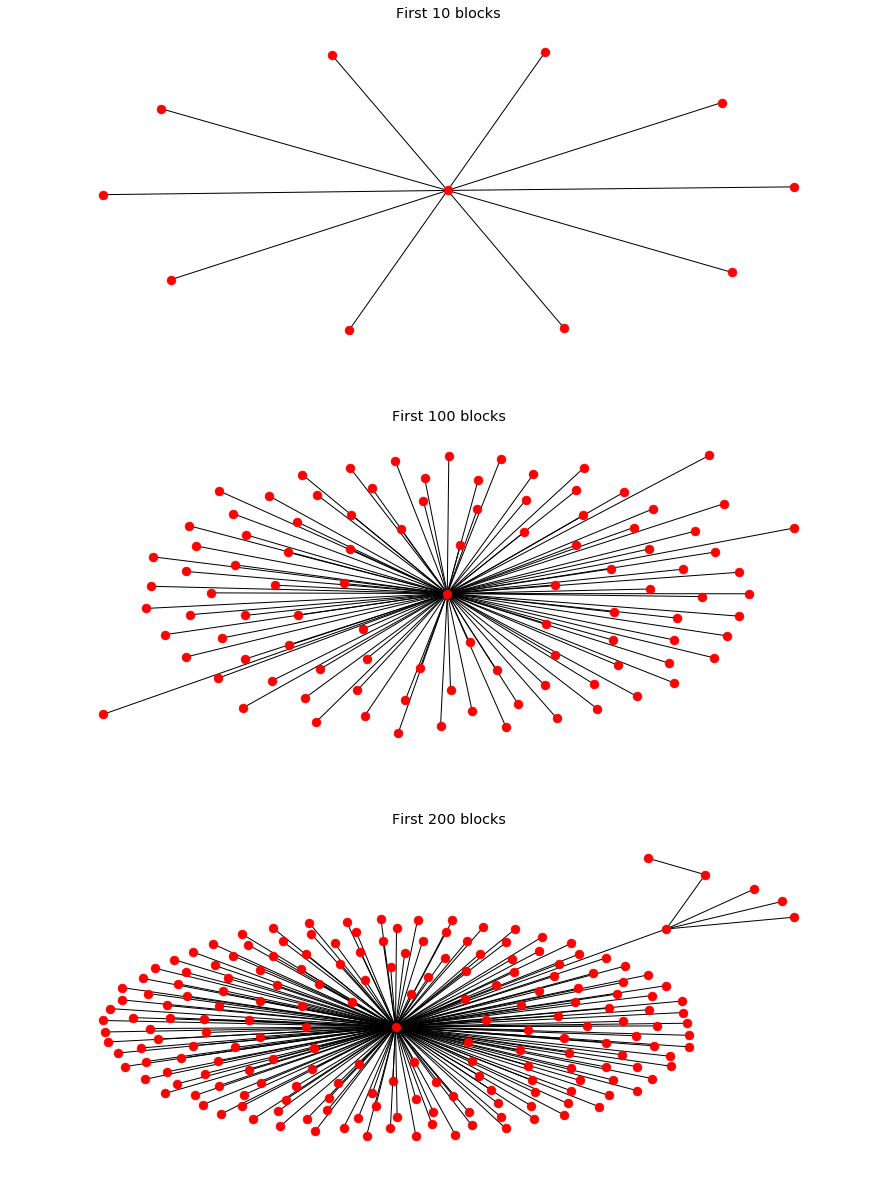

In [505]:
n_blocks = [10, 100, 200]
fig, ax_arr = plt.subplots(len(n_blocks),figsize=(15, len(n_blocks)*7))
for i in range(len(n_blocks)):
    btc_graph = nx.from_pandas_dataframe(graph_df.iloc[:n_blocks[i]], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'value','spent_flag'],
                                         create_using=nx.Graph())
    nx.draw_networkx(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])

    ax_arr[i].set(title='First {0} blocks'.format(n_blocks[i]))
    ax_arr[i].set_axis_off()


# Create the bitcoin transaction graph and extract key metrics

In [546]:
# Convert transaction graph data frame to edge list
# Edge lists networkx have the form
# to from data_dict

edge_df = graph_df[['addr_from', 'addr_to']]
edge_df['edge_data'] = graph_df[['height', 'value']].to_dict(orient='records')
edge_list = edge_df.values.tolist()

/Users/pavel/miniconda3/envs/qrm_pl/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [547]:
G = nx.MultiDiGraph(edge_list)#[0:5000])
#nx.draw_networkx(G, with_labels=False, node_size = 80)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))


Number of nodes: 50421
Number of edges: 61455


In [548]:
# Keep only nodes with valency at least 3
nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=2]
G = G.subgraph(nodes_ge3)
degs_in = G.in_degree()
#print(degs_in, '\n')
degs_out = G.out_degree()
#print(degs_out)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 9302
Number of edges: 20336


## Prepare nodes for hiveplot

In [550]:
nx.set_node_attributes(G, "degree_in", degs_in)
nx.set_node_attributes(G, "degree_out", degs_out)
# Assign "pure_miner" flag

In [551]:
#for n, d in G.nodes(data=True):
#    print(n, d)

#nodes['bc_mine'] = [(n,d) for n, d in G.nodes(data=True) if n == "mining"]
#G.node['1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa']["pure_miner"] = True
#G.node['1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa']

# Find transaction recipients
sender_keys = frozenset(np.unique([pub_key for pub_key in graph_df['addr_from'] if pub_key != 'mining']))
#sender_key_mask = graph_df['addr_from'].isin(sender_keys)
miner_addr = frozenset(graph_df.loc[graph_df['addr_from'] == 'mining', 'addr_to'])

#miners = miner_addr#.difference(sender_keys)
#player = sender_keys.difference(pure_miner)

for n in G.nodes_iter():
    if n in miner_addr:
        G.node[n]["miner"] = True
    else:
        G.node[n]["miner"] = False
# Identify nodes that have received mining btc but never sent btc
#sum(np.multiply(miner_mask, ~sender_key_mask))
#pure_miner_keys = graph_df.loc[~graph_df['addr_to'].isin(sender_keys), 'addr_from']

In [552]:
G.node[n]

{'degree_in': 2, 'degree_out': 0, 'miner': False}

In [553]:
nodes = dict()
#nodes['pure_miners'] = [(n,d) for n, d in G.nodes(data=True) if d['miner'] and d['degree_out'] == 0]
#nodes['pure_players'] = [(n,d) for n, d in G.nodes(data=True) if ~d['miner'] and n != 'mining']
nodes['spending_miner'] = [(n,d) for n, d in G.nodes(data=True) if d['miner'] and d['degree_out'] > 0]
nodes['give_and_take_non_miner'] = [(n,d) for n, d in G.nodes(data=True) if not d['miner'] and d['degree_out'] > 0
                         and d['degree_in'] > 0]
nodes['just_take_non_miner'] = [(n,d) for n, d in G.nodes(data=True) if not d['miner'] and d['degree_out'] == 0]
#nodes['players']
for group, nodelist in nodes.items():
    #print(nodelist)
    nodes[group] = sorted(nodelist, key=lambda node: node[1]['degree_out'])
    nodes[group] = [n for n, d in nodes[group]]

## Prepare edges for hiveplot

In [554]:
edges = dict()
#edges['mining_transaction'] = [(u,v,d) for u,v,d in G.edges(data=True) if u=='mining']
edges['p2p_transaction'] = [(u,v,d) for u,v,d in G.edges(data=True) if u!='mining']

## Set color schemes and plot

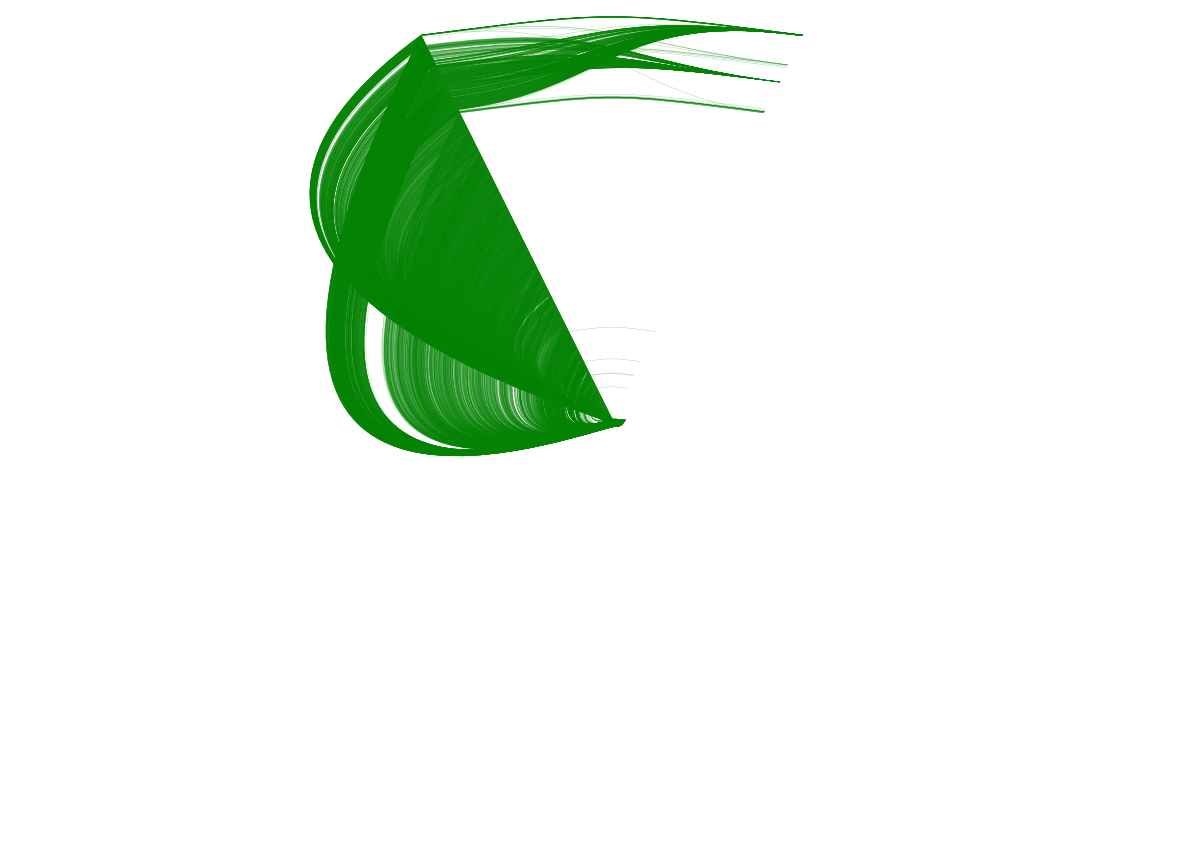

In [555]:
nodes_cmap = dict()
# nodes_cmap['pure_miners'] = 'black'
# nodes_cmap['pure_players'] = 'red'
# nodes_cmap['both'] = 'blue'
nodes_cmap['spending_miner'] = 'black'
nodes_cmap['give_and_take_non_miner'] = 'red'
nodes_cmap['just_take_non_miner'] = 'blue'

edges_cmap = dict()
#edges_cmap['mining_transaction'] = 'green'
edges_cmap['p2p_transaction'] = 'green'

fig, ax = plt.subplots(figsize=(20, 15))
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap, is_directed=True, fig=fig, ax=ax)
h.draw()

In [606]:
G.node[n]

{'degree_in': 2, 'degree_out': 0, 'miner': False}

## For the remainder remove all mining transactions

In [611]:
# Remove mining transactions and create edge list for node2vec
nodes_no_mine = [n for n in G.nodes() if n != 'miner']
G = G.subgraph(nodes_no_mine)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))


Number of nodes: 327
Number of edges: 535


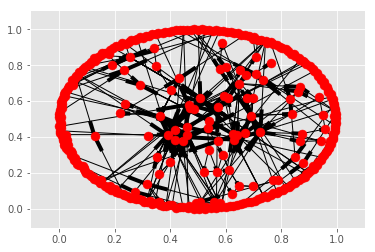

In [612]:
nx.draw_networkx(G, with_labels=False, node_size = 80)

In [620]:
G_n2v = n2v.Graph(G, True,1,2)


In [624]:
#G_n2v.node2vec_walk()

<bound method Graph.node2vec_walk of <node2vec.node2vec.Graph object at 0x13df26668>>

In [160]:
nx.triadic_census(G)

{'003': 1234826,
 '012': 1908,
 '021C': 5,
 '021D': 18151,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}

In [146]:
nodes


{'mining_payments': [('mining', {'degree_in': 0, 'degree_out': 10})],
 'players': [],
 'pure_miners': [('1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa',
   {'degree_in': 1, 'degree_out': 0}),
  ('12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX', {'degree_in': 1, 'degree_out': 0}),
  ('1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1', {'degree_in': 1, 'degree_out': 0}),
  ('1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR', {'degree_in': 1, 'degree_out': 0}),
  ('15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG', {'degree_in': 1, 'degree_out': 0}),
  ('1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu', {'degree_in': 1, 'degree_out': 0}),
  ('1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a', {'degree_in': 1, 'degree_out': 0}),
  ('16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM', {'degree_in': 1, 'degree_out': 0}),
  ('1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj', {'degree_in': 1, 'degree_out': 0}),
  ('12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S', {'degree_in': 1, 'degree_out': 0})]}

In [143]:
nodes

{'mining_payments': [('mining', {'degree_in': 0, 'degree_out': 10})],
 'pure_miners': [('1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa',
   {'degree_in': 1, 'degree_out': 0}),
  ('12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX', {'degree_in': 1, 'degree_out': 0}),
  ('1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1', {'degree_in': 1, 'degree_out': 0}),
  ('1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR', {'degree_in': 1, 'degree_out': 0}),
  ('15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG', {'degree_in': 1, 'degree_out': 0}),
  ('1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu', {'degree_in': 1, 'degree_out': 0}),
  ('1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a', {'degree_in': 1, 'degree_out': 0}),
  ('16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM', {'degree_in': 1, 'degree_out': 0}),
  ('1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj', {'degree_in': 1, 'degree_out': 0}),
  ('12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S', {'degree_in': 1, 'degree_out': 0})]}